In [1]:
import pybamm
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)

########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

In [2]:
S8_initial_g = 2.6565990721396795
S6_initial_g = 0.03308746536461487
S4_initial_g = 0.013008078277994115
S2_initial_g = 2.8449317677625998e-08
S1_initial_g = 4.404388467562549e-12
Sp_initial_g = 2.6636551382083317e-06

# the total active material mass
m_s = S8_initial_g + S6_initial_g + S4_initial_g + S2_initial_g + S1_initial_g + Sp_initial_g

# get the mass fractions of the initial conditions
S8_initial_frac = S8_initial_g/m_s
S6_initial_frac = S6_initial_g/m_s
S4_initial_frac = S4_initial_g/m_s
S2_initial_frac = S2_initial_g/m_s
S1_initial_frac = S1_initial_g/m_s
Sp_initial_frac = Sp_initial_g/m_s

# set new total activate material mass to give Hunt's 0.211 Ah cell capacity
m_s_hunt = .168*1.5

# define the current for later simulations
current = 0.0211*2

# define discharge time in seconds for later simulations
hours = 10/2
time_in_seconds = hours*3600

S8_initial_hunt = S8_initial_frac*m_s_hunt*3
S6_initial_hunt = S6_initial_frac*m_s_hunt
S4_initial_hunt = S4_initial_frac*m_s_hunt
S2_initial_hunt = S2_initial_frac*m_s_hunt
S1_initial_hunt = S1_initial_frac*m_s_hunt
Sp_initial_hunt = Sp_initial_frac*m_s_hunt
V_initial_hunt = 2.4

# these are global variables to avoid needing to input them 
# we are not fitting initial conditions yet
discharge_initial_data = [V_initial_hunt, 
        S8_initial_hunt, 
        S6_initial_hunt,
        S4_initial_hunt, 
        S2_initial_hunt, 
        S1_initial_hunt, 
        Sp_initial_hunt]

model = pybamm.lithium_sulfur.Cornish_pseudospatial()

# (similar) parameters should be the same as in Marinescu et al. (2018)
# However, the  initial condition from charge appears to be the result of a discharge
current = 2*0.0211
hours = 15
time_in_seconds = 5000#hours*3600
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": current,
        "Initial Condition for S8 ion [g]": discharge_initial_data[1],
        "Initial Condition for S6 ion [g]": discharge_initial_data[2],
        "Initial Condition for S4 ion [g]": discharge_initial_data[3],
        "Initial Condition for S2 ion [g]": discharge_initial_data[4],
        "Initial Condition for S ion [g]": discharge_initial_data[5],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[6],
        "Initial Condition for Terminal Voltage [V]": 2.4,#V_initial,
        #"Precipitation rate [s-1]": 50,
        #"Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Lower voltage cut-off [V]": 2.0,
        "Standard Potential L [V]": 2.0,
        "Standard Potential M [V]": 2.0,
        "Standard Potential H [V]": 2.38,
        "gamma": 0,#25000,
        "kappa" : 0#,15,
        #"S saturation mass [g]": 1e-6,
        #"Electrolyte volume per cell [L]": 0.0114*.25
    }
)
params.process_model(model)
sim_cornish_pseudospatial_quick = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, 
        rtol=1e-3, 
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
        #root_method = 'lm',
        #root_tol = 1e-7, 
        #dt_max = 1e-7
    ),
)
sim_cornish_pseudospatial_quick.solve(np.linspace(0, time_in_seconds, 1000))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

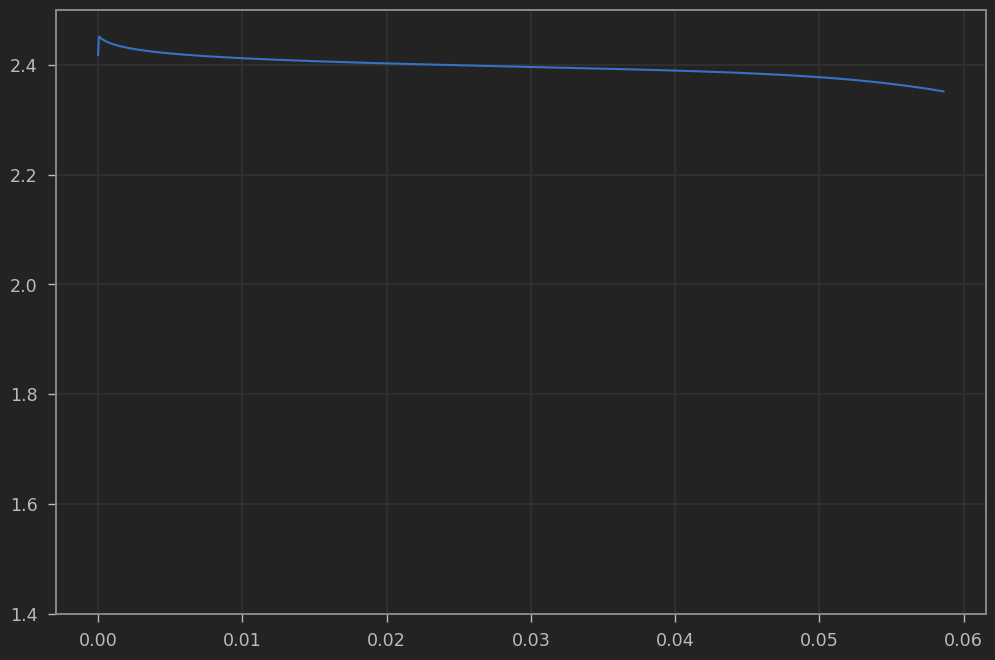

In [3]:
voltage_cornish_pseudospatial = sim_cornish_pseudospatial_quick.solution['Terminal voltage [V]'].entries
capacity_cornish_pseudospatial = abs(current)*sim_cornish_pseudospatial_quick.solution.t/3600
plt.plot(capacity_cornish_pseudospatial,voltage_cornish_pseudospatial)
plt.ylim([1.4,2.5])
plt.grid(True)
notify

In [4]:
x = np.where(voltage_cornish_pseudospatial <= 2.4)
loc = x[0][0]

In [5]:
S8_initial_cornish = sim_cornish_pseudospatial_quick.solution['S8 [g]'].entries[loc]
S6_initial_cornish = sim_cornish_pseudospatial_quick.solution['S6 [g]'].entries[loc]
S4_initial_cornish = sim_cornish_pseudospatial_quick.solution['S4 [g]'].entries[loc]
S2_initial_cornish = sim_cornish_pseudospatial_quick.solution['S2 [g]'].entries[loc]
S_initial_cornish = sim_cornish_pseudospatial_quick.solution['S [g]'].entries[loc]
Sp_initial_cornish = sim_cornish_pseudospatial_quick.solution["Precipitated Sulfur [g]"].entries[loc]
V_initial_cornish = sim_cornish_pseudospatial_quick.solution['Terminal voltage [V]'].entries[loc]

In [6]:
data = {}
for precip in [1000, 100, 10, 1]:
    try:
        model = pybamm.lithium_sulfur.Cornish()

        # (similar) parameters should be the same as in Marinescu et al. (2018)
        # However, the  initial condition from charge appears to be the result of a discharge
        current = 2*0.0211
        hours = 15
        time_in_seconds = 18000#hours*3600
        params = model.default_parameter_values
        params.update(
            {
                "Current function [A]": current,
                "Initial Condition for S8 ion [g]": S8_initial_cornish,
                "Initial Condition for S6 ion [g]": S6_initial_cornish,
                "Initial Condition for S4 ion [g]": S4_initial_cornish,
                "Initial Condition for S2 ion [g]": S2_initial_cornish,
                "Initial Condition for S ion [g]": S_initial_cornish,
                "Initial Condition for Precipitated Sulfur [g]": Sp_initial_cornish,
                "Initial Condition for Terminal Voltage [V]": 2.4,#V_initial,
                "Precipitation rate [s-1]": precip,
                #"Shuttle rate coefficient during discharge [s-1]": 0.0002,
                "Lower voltage cut-off [V]": 2.0,
                "Standard Potential L [V]": 2.0,
                "Standard Potential M [V]": 2.0,
                "Standard Potential H [V]": 2.38,
                "gamma": 0,#25000,
                "kappa" : 0,#15,
                #"S saturation mass [g]": 1e-6,
                #"Electrolyte volume per cell [L]": 0.0114*.25
            }
        )
        params.process_model(model)
        sim_cornish_pseudospatial = pybamm.Simulation(
            model,
            parameter_values=params,
            solver=pybamm.CasadiSolver(
                atol=1e-6, 
                rtol=1e-3, 
                extra_options_setup={"max_step_size": 0.1}, 
                max_step_decrease_count = 15,
                #root_method = 'lm',
                #root_tol = 1e-7, 
                #dt_max = 1e-7
            ),
        )
        sim_cornish_pseudospatial.solve(np.linspace(0, time_in_seconds, 1000))

        data[str(precip)] = sim_cornish_pseudospatial
    except:
        pass

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed


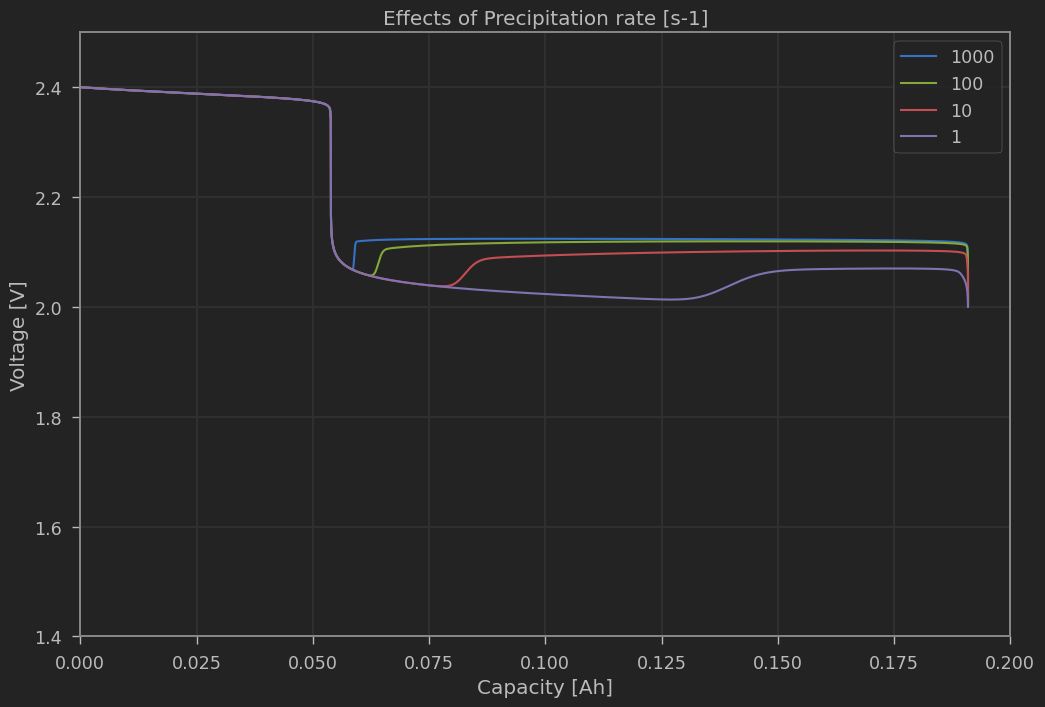

In [7]:
for sim in data.values():
    voltage_cornish = sim.solution['Terminal voltage [V]'].entries
    capacity_cornish = abs(current)*sim.solution.t/3600
    plt.plot(capacity_cornish,voltage_cornish)
plt.ylim([1.4,2.5])
plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title('Effects of Precipitation rate [s-1]')
plt.legend(data.keys())
plt.grid(True)
notify

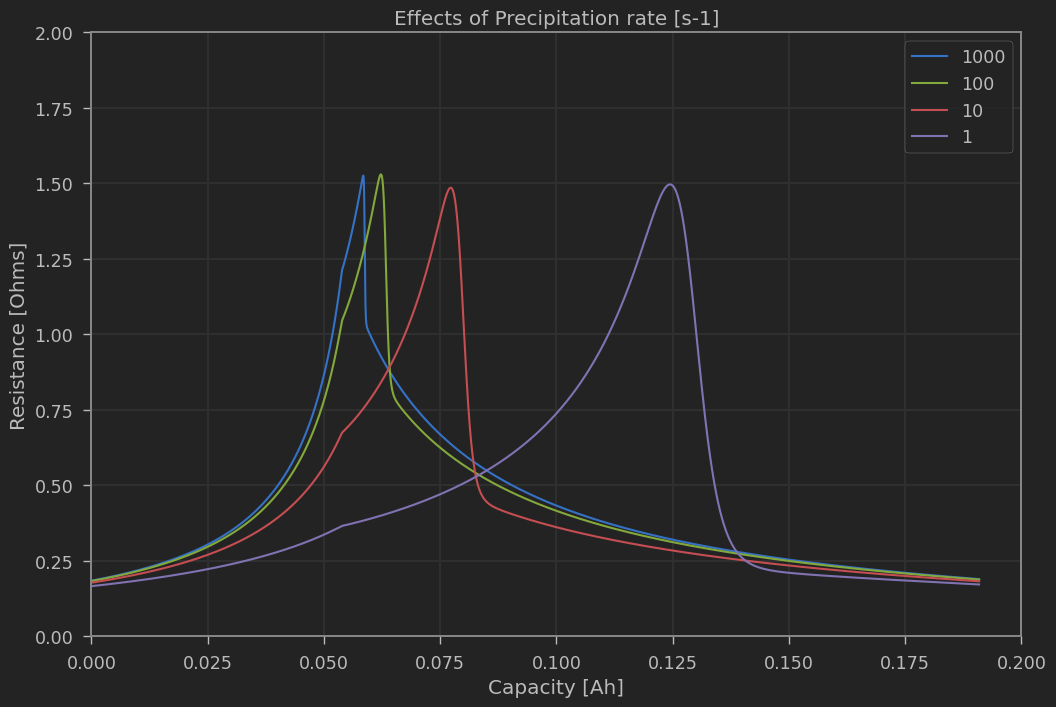

In [8]:
sigma_0 = 2e-3
l =  4e-5
A = 0.15
i = 0
for sim in data.values():
    capacity_cornish = abs(current)*sim.solution.t/3600
    S6 = sim.solution['S6 [g]'].entries
    S4 = sim.solution['S4 [g]'].entries
    S2 = sim.solution['S2 [g]'].entries
    S1 = sim.solution['S [g]'].entries
    Li = S1 + 0.5*S2 + 0.25*S4 + (1/6)*S6
    if i == 2:
        b = 1.145e-2
    elif i == 1:
        b = 1.245e-2
    elif i == 3:
        b = 9.07e-3
    else:
        b = 1.27e-2
    sigma = sigma_0 - b*(Li)
    R = l/(A*sigma)
    plt.plot(capacity_cornish,R)
    i += 1
plt.ylim([0,2])
plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [Ohms]')
plt.title('Effects of Precipitation rate [s-1]')
plt.legend(data.keys())
plt.grid(True)
notify

In [9]:
data_sat = {}
for sat in [1e-7, 1e-6, 1e-5, 1e-4]:
    try:
        model = pybamm.lithium_sulfur.Cornish()

        # (similar) parameters should be the same as in Marinescu et al. (2018)
        # However, the  initial condition from charge appears to be the result of a discharge
        current = 2*0.0211
        hours = 15
        time_in_seconds = 17000#hours*3600
        params = model.default_parameter_values
        params.update(
            {
                "Current function [A]": current,
                "Initial Condition for S8 ion [g]": S8_initial_cornish,
                "Initial Condition for S6 ion [g]": S6_initial_cornish,
                "Initial Condition for S4 ion [g]": S4_initial_cornish,
                "Initial Condition for S2 ion [g]": S2_initial_cornish,
                "Initial Condition for S ion [g]": S_initial_cornish,
                "Initial Condition for Precipitated Sulfur [g]": Sp_initial_cornish,
                "Initial Condition for Terminal Voltage [V]": 2.4,#V_initial,
                #"Precipitation rate [s-1]": precip,
                #"Shuttle rate coefficient during discharge [s-1]": 0.0002,
                "Lower voltage cut-off [V]": 2.0,
                "Standard Potential L [V]": 2.0,
                "Standard Potential M [V]": 2.0,
                "Standard Potential H [V]": 2.38,
                "gamma": 0,#25000,
                "kappa" : 0,#15,
                "S saturation mass [g]": sat,
                #"Electrolyte volume per cell [L]": 0.0114*.25
            }
        )
        params.process_model(model)
        sim_cornish_pseudospatial = pybamm.Simulation(
            model,
            parameter_values=params,
            solver=pybamm.CasadiSolver(
                atol=1e-6, 
                rtol=1e-3, 
                extra_options_setup={"max_step_size": 0.1}, 
                max_step_decrease_count = 15,
                #root_method = 'lm',
                #root_tol = 1e-7, 
                #dt_max = 1e-7
            ),
        )
        sim_cornish_pseudospatial.solve(np.linspace(0, time_in_seconds, 10000))

        data_sat[str(sat)] = sim_cornish_pseudospatial
    except:
        pass

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
The residual routine or the linear setup or solve routine had a recoverable error, but IDACalcIC was unable to recover.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian faile

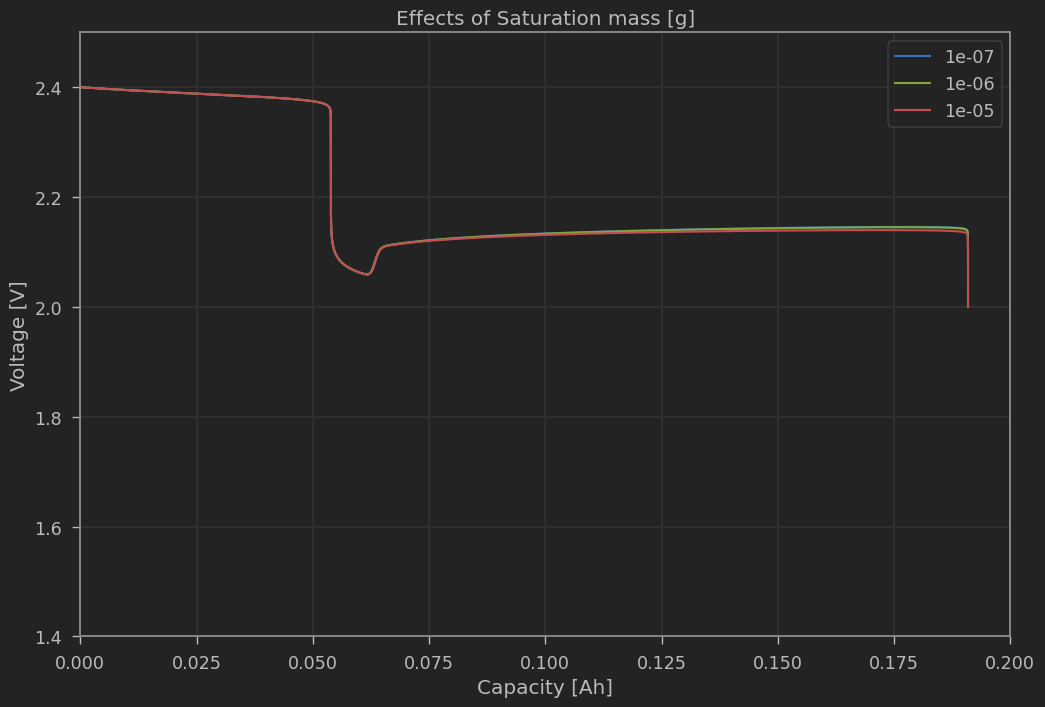

In [10]:
for sim in data_sat.values():
    voltage_cornish = sim.solution['Terminal voltage [V]'].entries
    capacity_cornish = abs(current)*sim.solution.t/3600
    plt.plot(capacity_cornish,voltage_cornish)
plt.ylim([1.4,2.5])
plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title('Effects of Saturation mass [g]')
plt.legend(data_sat.keys())
plt.grid(True)
notify

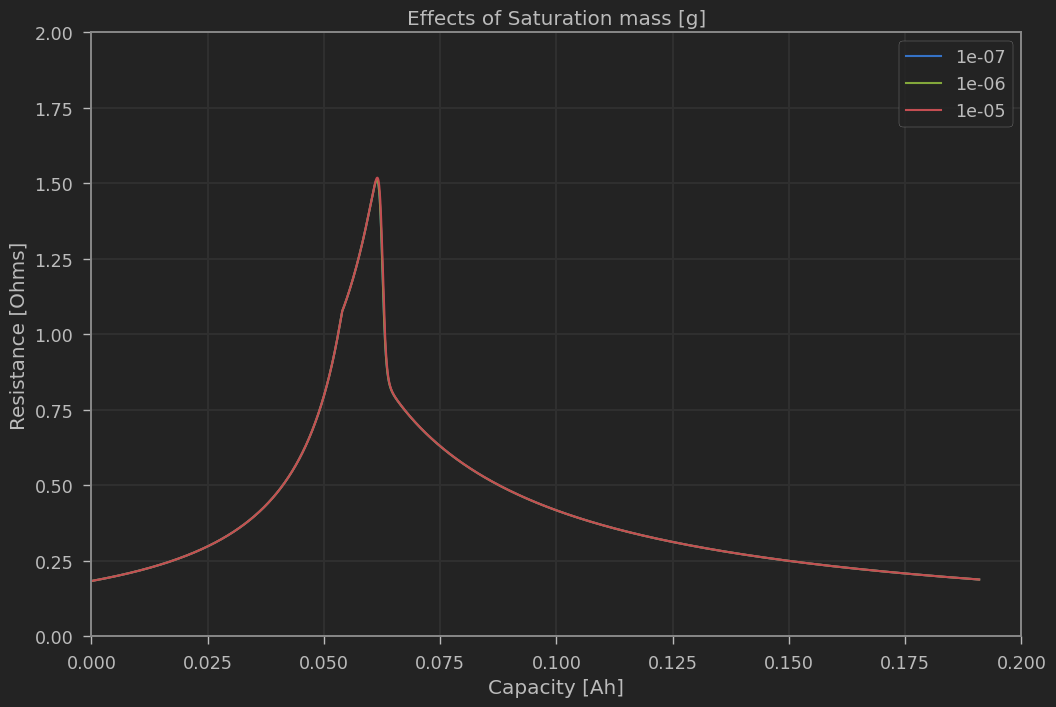

In [11]:
sigma_0 = 2e-3
l =  4e-5
A = 0.15
i = 0
for sim in data_sat.values():
    capacity_cornish = abs(current)*sim.solution.t/3600
    S6 = sim.solution['S6 [g]'].entries
    S4 = sim.solution['S4 [g]'].entries
    S2 = sim.solution['S2 [g]'].entries
    S1 = sim.solution['S [g]'].entries
    Li = S1 + 0.5*S2 + 0.25*S4 + (1/6)*S6
    if i == 2:
        b = 1.25e-2
    elif i == 1:
        b = 1.25e-2
    elif i == 3:
        b = 1.244e-2
    else:
        b = 1.25e-2
    sigma = sigma_0 - b*(Li)
    R = l/(A*sigma)
    plt.plot(capacity_cornish,R)
    i += 1
plt.ylim([0,2])
plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [Ohms]')
plt.title('Effects of Saturation mass [g]')
plt.legend(data_sat.keys())
plt.grid(True)
notify

In [12]:
model = pybamm.lithium_sulfur.Cornish()

# (similar) parameters should be the same as in Marinescu et al. (2018)
# However, the  initial condition from charge appears to be the result of a discharge
current = 2*0.0211
hours = 15
time_in_seconds = 18000#hours*3600
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": current,
        "Initial Condition for S8 ion [g]": S8_initial_cornish,
        "Initial Condition for S6 ion [g]": S6_initial_cornish,
        "Initial Condition for S4 ion [g]": S4_initial_cornish,
        "Initial Condition for S2 ion [g]": S2_initial_cornish,
        "Initial Condition for S ion [g]": S_initial_cornish,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial_cornish,
        "Initial Condition for Terminal Voltage [V]": 2.4,#V_initial,
        #"Precipitation rate [s-1]": precip,
        #"Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Lower voltage cut-off [V]": 2.0,
        "Standard Potential L [V]": 2.0,
        "Standard Potential M [V]": 2.0,
        "Standard Potential H [V]": 2.38,
        "gamma": 0,#25000,
        "kappa" : 0,#15,
        #"S saturation mass [g]": sat,
        #"Electrolyte volume per cell [L]": 0.0114*.25
    }
)
params.process_model(model)
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, 
        rtol=1e-3, 
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
        #root_method = 'lm',
        #root_tol = 1e-7, 
        #dt_max = 1e-7
    ),
)
sim.solve(np.linspace(0, time_in_seconds, 1000))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

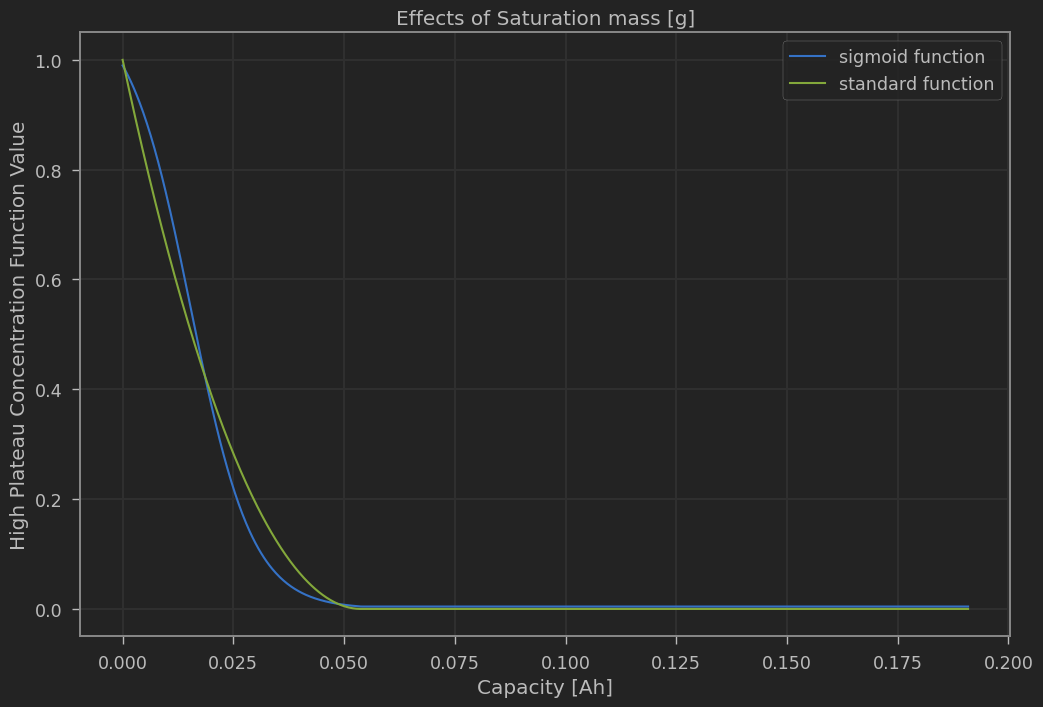

In [13]:
S8 = sim.solution['S8 [g]'].entries
S8_init = S8[0]
S6 = sim.solution['S6 [g]'].entries
S6_init = S6[0]
S4 = sim.solution['S4 [g]'].entries
S4_init = S4[0]
capacity_cornish = abs(current)*sim.solution.t/3600
g_cornish = 2.2*(1/(1 + 250*np.exp(-15*(S8))))*(1/(1 + np.exp(0*(S6+S4))))
g_bockris = (S8/S8_init)**(2)*(S6/S6_init)**(-.01)*(S4/S4_init)**(-.01)

plt.plot(capacity_cornish,g_cornish)
plt.plot(capacity_cornish,g_bockris)
plt.xlabel('Capacity [Ah]')
plt.ylabel('High Plateau Concentration Function Value')
plt.title('Effects of Saturation mass [g]')
plt.legend(['sigmoid function','standard function'])
plt.grid(True)

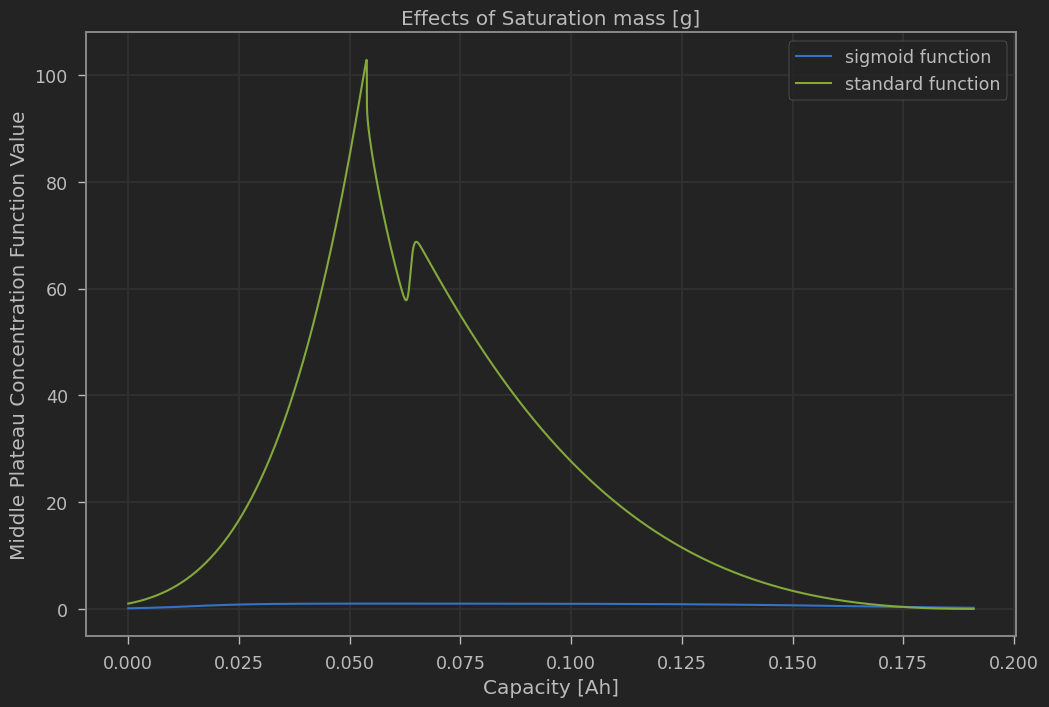

In [14]:
S2 = sim.solution['S2 [g]'].entries
S2_init = S2[0]
S6 = sim.solution['S6 [g]'].entries
S6_init = S6[0]
S4 = sim.solution['S4 [g]'].entries
S4_init = S4[0]
capacity_cornish = abs(current)*sim.solution.t/3600
g_cornish = 2*(1/(1 + 250*np.exp(-15*(S6+S4))))*(1/(1 + np.exp(0*(2))))
g_bockris = (S2/S2_init)**(-0.01)*(S6/S6_init)**(2)*(S4/S4_init)**(2)

plt.plot(capacity_cornish,g_cornish)
plt.plot(capacity_cornish,g_bockris)
plt.xlabel('Capacity [Ah]')
plt.ylabel('Middle Plateau Concentration Function Value')
plt.title('Effects of Saturation mass [g]')
plt.legend(['sigmoid function','standard function'])
plt.grid(True)

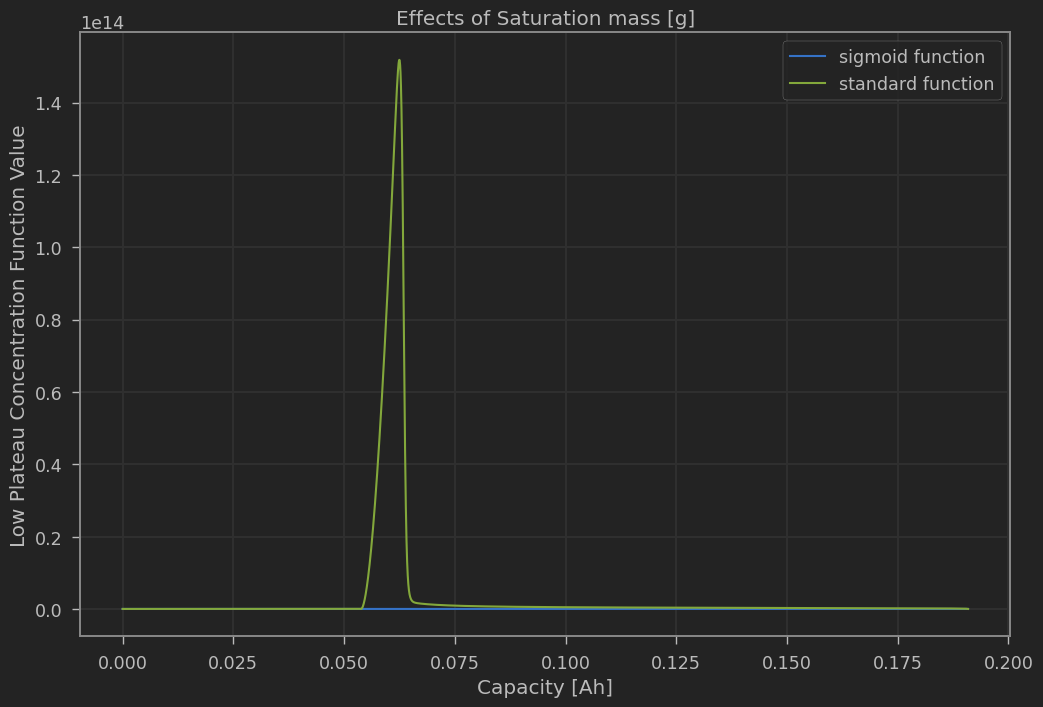

In [15]:
S2 = sim.solution['S2 [g]'].entries
S2_init = S2[0]
S1 = sim.solution['S [g]'].entries
S1_init = S1[0]
capacity_cornish = abs(current)*sim.solution.t/3600
g_cornish = 2*(1/(1 + 250*np.exp(-15*(S2))))*(1/(1 + np.exp(0*(S1))))
g_bockris = (S1/S1_init)**(-0.01)*(S2/S2_init)**(2)

plt.plot(capacity_cornish,g_cornish)
plt.plot(capacity_cornish,g_bockris)
plt.xlabel('Capacity [Ah]')
plt.ylabel('Low Plateau Concentration Function Value')
plt.title('Effects of Saturation mass [g]')
plt.legend(['sigmoid function','standard function'])
plt.grid(True)

In [16]:
model = pybamm.lithium_sulfur.Cornish_concentration()

# (similar) parameters should be the same as in Marinescu et al. (2018)
# However, the  initial condition from charge appears to be the result of a discharge
current = 2*0.0211
hours = 15
time_in_seconds = 18000#hours*3600
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": current,
        "Initial Condition for S8 ion [g]": S8_initial_cornish,
        "Initial Condition for S6 ion [g]": S6_initial_cornish,
        "Initial Condition for S4 ion [g]": S4_initial_cornish,
        "Initial Condition for S2 ion [g]": S2_initial_cornish,
        "Initial Condition for S ion [g]": S_initial_cornish,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial_cornish,
        "Initial Condition for Terminal Voltage [V]": 2.4,#V_initial,
        #"Precipitation rate [s-1]": precip,
        #"Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Lower voltage cut-off [V]": 2.0,
        "Standard Potential L [V]": 2.0,
        "Standard Potential M [V]": 2.0,
        "Standard Potential H [V]": 2.38,
        "gamma": .01,
        "kappa" : 2,
        #"S saturation mass [g]": sat,
        #"Electrolyte volume per cell [L]": 0.0114*.25
    }
)
params.process_model(model)
sim_con = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, 
        rtol=1e-3, 
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
        #root_method = 'lm',
        #root_tol = 1e-7, 
        #dt_max = 1e-7
    ),
)
sim_con.solve(np.linspace(0, time_in_seconds, 1000))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 4522.45 and h = 7.04516e-08, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

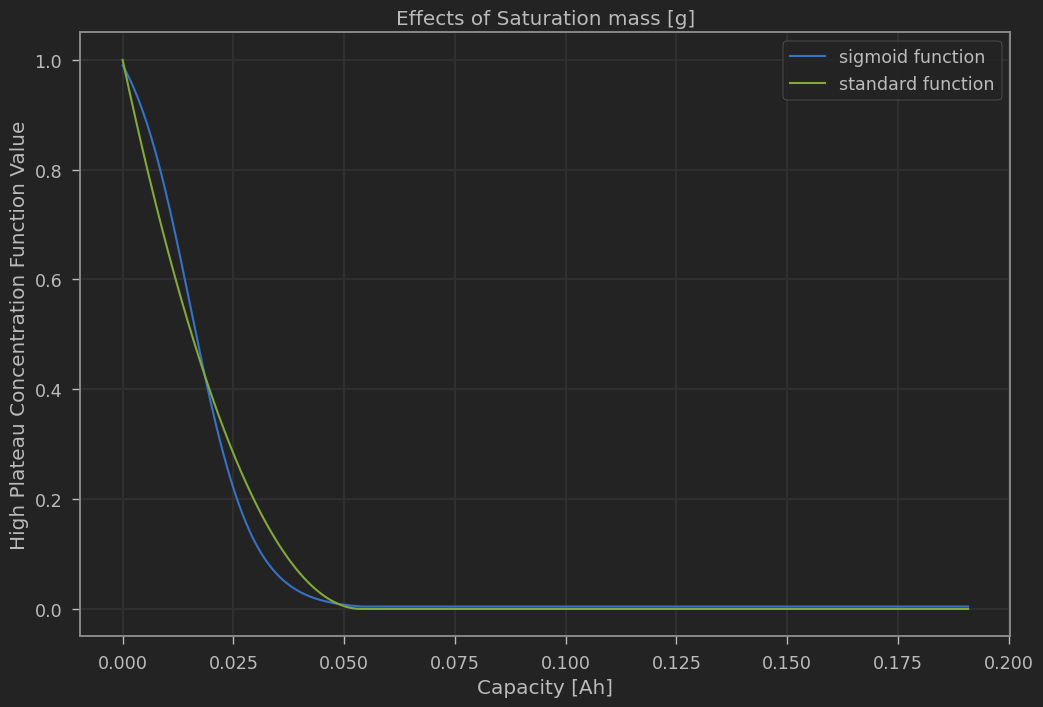

In [17]:
S8 = sim_con.solution['S8 [g]'].entries
S8_init = S8[0]
S6 = sim_con.solution['S6 [g]'].entries
S6_init = S6[0]
S4 = sim_con.solution['S4 [g]'].entries
S4_init = S4[0]
capacity_cornish = abs(current)*sim_con.solution.t/3600
g_cornish = 2.2*(1/(1 + 250*np.exp(-15*(S8))))*(1/(1 + np.exp(0*(S6+S4))))
g_bockris = (S8/S8_init)**(2)*(S6/S6_init)**(-.01)*(S4/S4_init)**(-.01)

plt.plot(capacity_cornish,g_cornish)
plt.plot(capacity_cornish,g_bockris)
plt.xlabel('Capacity [Ah]')
plt.ylabel('High Plateau Concentration Function Value')
plt.title('Effects of Saturation mass [g]')
plt.legend(['sigmoid function','standard function'])
plt.grid(True)

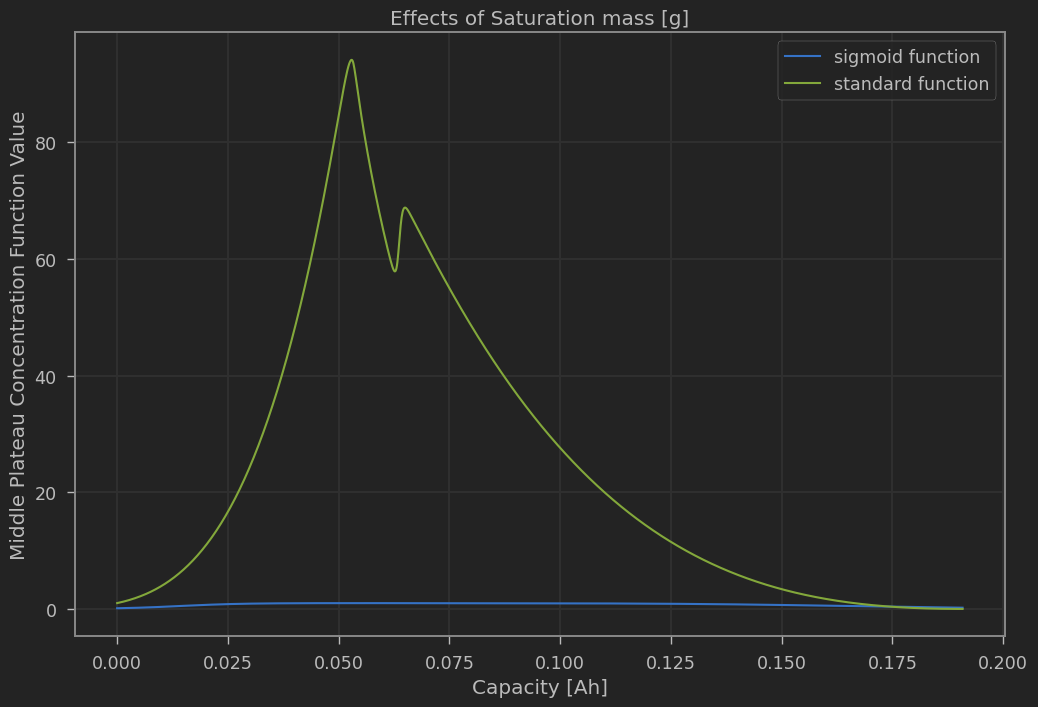

In [18]:
S2 = sim_con.solution['S2 [g]'].entries
S2_init = S2[0]
S6 = sim_con.solution['S6 [g]'].entries
S6_init = S6[0]
S4 = sim_con.solution['S4 [g]'].entries
S4_init = S4[0]
capacity_cornish = abs(current)*sim_con.solution.t/3600
g_cornish = 2*(1/(1 + 250*np.exp(-15*(S6+S4))))*(1/(1 + np.exp(0*(2))))
g_bockris = (S2/S2_init)**(-0.01)*(S6/S6_init)**(2)*(S4/S4_init)**(2)

plt.plot(capacity_cornish,g_cornish)
plt.plot(capacity_cornish,g_bockris)
plt.xlabel('Capacity [Ah]')
plt.ylabel('Middle Plateau Concentration Function Value')
plt.title('Effects of Saturation mass [g]')
plt.legend(['sigmoid function','standard function'])
plt.grid(True)

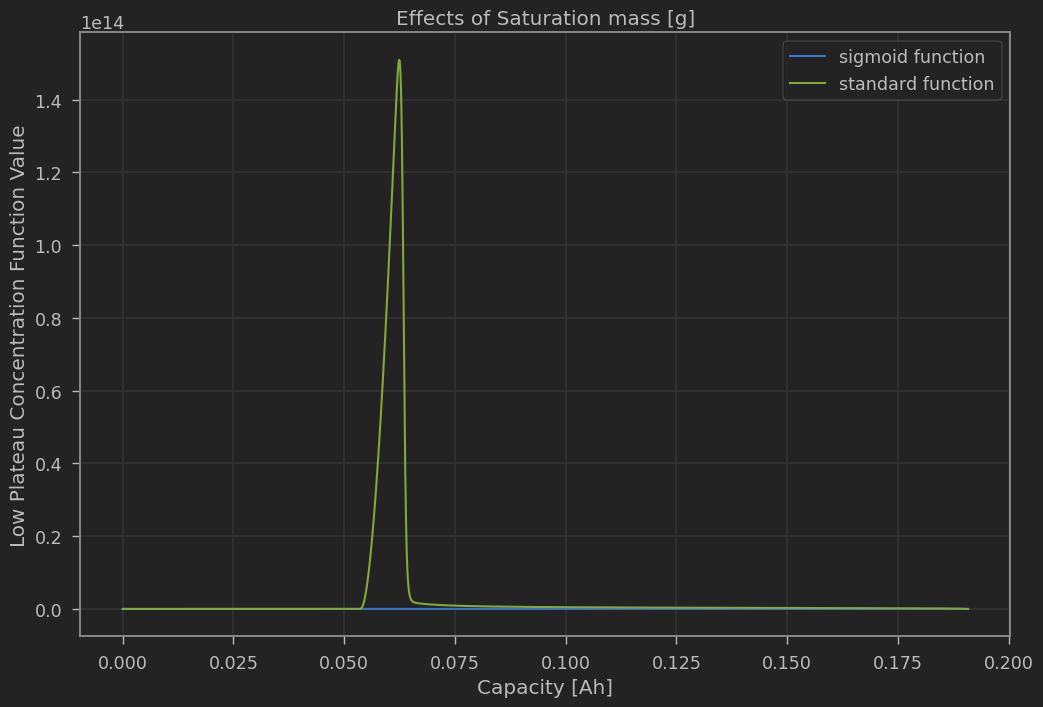

In [19]:
S2 = sim_con.solution['S2 [g]'].entries
S2_init = S2[0]
S1 = sim_con.solution['S [g]'].entries
S1_init = S1[0]
capacity_cornish = abs(current)*sim_con.solution.t/3600
g_cornish = 2*(1/(1 + 250*np.exp(-15*(S2))))*(1/(1 + np.exp(0*(S1))))
g_bockris = (S1/S1_init)**(-0.01)*(S2/S2_init)**(2)

plt.plot(capacity_cornish,g_cornish)
plt.plot(capacity_cornish,g_bockris)
plt.xlabel('Capacity [Ah]')
plt.ylabel('Low Plateau Concentration Function Value')
plt.title('Effects of Saturation mass [g]')
plt.legend(['sigmoid function','standard function'])
plt.grid(True)

In [20]:
model = pybamm.lithium_sulfur.Cornish_concentration_custom()

# (similar) parameters should be the same as in Marinescu et al. (2018)
# However, the  initial condition from charge appears to be the result of a discharge
current = 2*0.0211
hours = 15
time_in_seconds =18000#hours*3600
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": current,
        "Initial Condition for S8 ion [g]": S8_initial_cornish,
        "Initial Condition for S6 ion [g]": S6_initial_cornish,
        "Initial Condition for S4 ion [g]": S4_initial_cornish,
        "Initial Condition for S2 ion [g]": S2_initial_cornish,
        "Initial Condition for S ion [g]": S_initial_cornish,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial_cornish,
        "Initial Condition for Terminal Voltage [V]": 2.4,#V_initial,
        #"Precipitation rate [s-1]": precip,
        #"Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Lower voltage cut-off [V]": 2.0,
        "Standard Potential L [V]": 2.0,
        "Standard Potential M [V]": 2.0,
        "Standard Potential H [V]": 2.38,
        "gamma": 200,#300,
        "kappa" : 20,#25,
        #"S saturation mass [g]": sat,
        #"Electrolyte volume per cell [L]": 0.0114*.25
    }
)
params.process_model(model)
sim_con_cust = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, 
        rtol=1e-3, 
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
        #root_method = 'lm',
        #root_tol = 1e-7, 
        #dt_max = 1e-7
    ),
)
sim_con_cust.solve(np.linspace(0, time_in_seconds, 2000))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

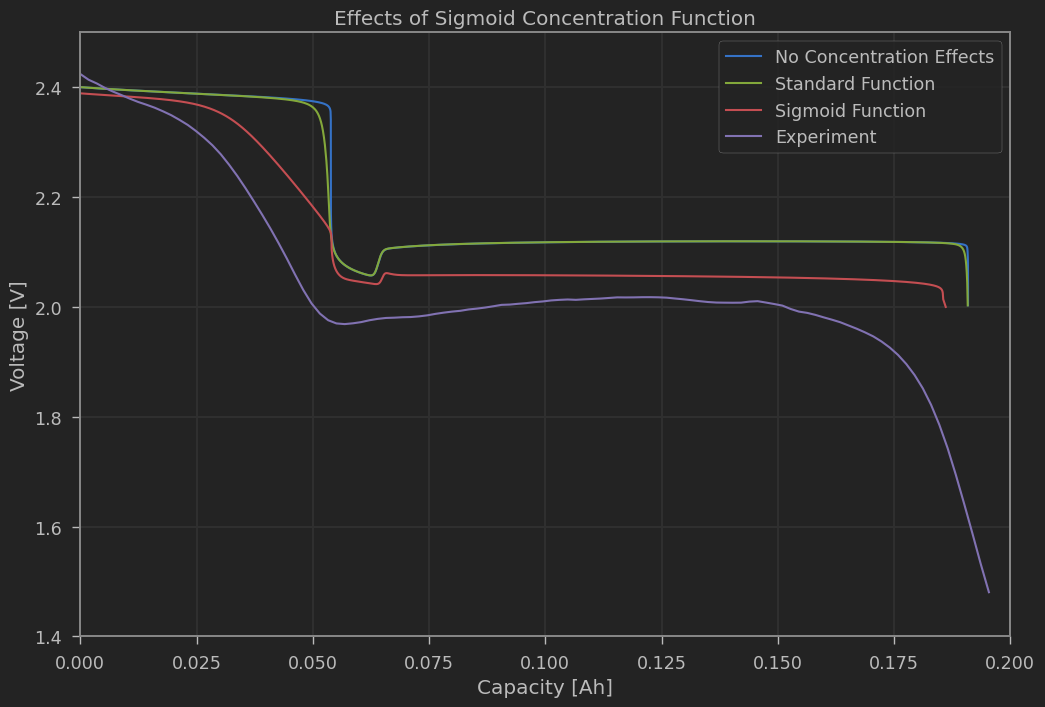

In [21]:
voltage_cornish = sim.solution['Terminal voltage [V]'].entries
capacity_cornish = abs(current)*sim.solution.t/3600
plt.plot(capacity_cornish,voltage_cornish)

voltage_cornish = sim_con.solution['Terminal voltage [V]'].entries
capacity_cornish = abs(current)*sim_con.solution.t/3600
plt.plot(capacity_cornish,voltage_cornish)

voltage_cornish = sim_con_cust.solution['Terminal voltage [V]'].entries
capacity_cornish = abs(current)*sim_con_cust.solution.t/3600
plt.plot(capacity_cornish,voltage_cornish)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

temp_list = list(discharge_data.keys())

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])

plt.ylim([1.4,2.5])
plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title('Effects of Sigmoid Concentration Function')
plt.legend(['No Concentration Effects','Standard Function', 'Sigmoid Function', 'Experiment'])
plt.grid(True)
notify

In [22]:
model = pybamm.lithium_sulfur.Cornish_concentration_custom()

# (similar) parameters should be the same as in Marinescu et al. (2018)
# However, the  initial condition from charge appears to be the result of a discharge
current = 2*0.0211
hours = 15
time_in_seconds =18000#hours*3600
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": current,
        "Initial Condition for S8 ion [g]": S8_initial_cornish,
        "Initial Condition for S6 ion [g]": S6_initial_cornish,
        "Initial Condition for S4 ion [g]": S4_initial_cornish,
        "Initial Condition for S2 ion [g]": S2_initial_cornish,
        "Initial Condition for S ion [g]": S_initial_cornish,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial_cornish,
        "Initial Condition for Terminal Voltage [V]": 2.4,#V_initial,
        #"Precipitation rate [s-1]": precip,
        "Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Lower voltage cut-off [V]": 2.0,
        "Standard Potential L [V]": 2.0,
        "Standard Potential M [V]": 2.0,
        "Standard Potential H [V]": 2.38,
        "gamma": 200,#300,
        "kappa" : 20,#25,
        #"S saturation mass [g]": sat,
        #"Electrolyte volume per cell [L]": 0.0114*.25
    }
)
params.process_model(model)
sim_con_cust = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, 
        rtol=1e-3, 
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
        #root_method = 'lm',
        #root_tol = 1e-7, 
        #dt_max = 1e-7
    ),
)
sim_con_cust.solve(np.linspace(0, time_in_seconds, 2000))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

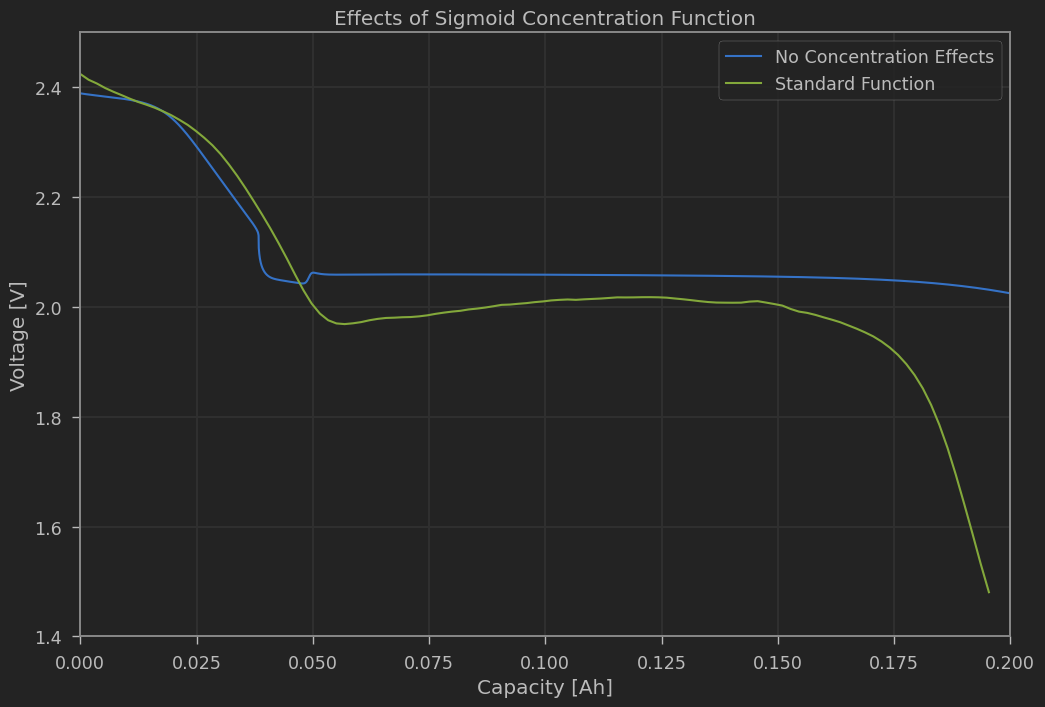

In [23]:
voltage_cornish = sim_con_cust.solution['Terminal voltage [V]'].entries
capacity_cornish = abs(current)*sim_con_cust.solution.t/3600
plt.plot(capacity_cornish,voltage_cornish)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

temp_list = list(discharge_data.keys())

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])

plt.ylim([1.4,2.5])
plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title('Effects of Sigmoid Concentration Function')
plt.legend(['No Concentration Effects','Standard Function', 'Sigmoid Function', 'Experiment'])
plt.grid(True)
notify